# Chi-squared Distribution ($k=1$)


## Theory
Given a standard random variable $X \sim \mathcal{N}(0,1)$ we would like to find the random variable $Y = X^2$.
The analytic solution is known: $Y$ follows a chi-squared distribution with $k=1$ degree of freedom.

Using polynomial chaos expansion (PCE), the problem can be solved using Galerkin projection.
Let $\{\phi_k \}_{k=0}^{n}$ be the monic orthogonal basis relative to the probability density of $X$, namely
$$
f_X(x) = \frac{1}{\sqrt{2 \pi}} \exp \left( - \frac{x^2}{2} \right).
$$
Then, the PCE of $X$ is given by
$$
X = \sum_{k=0}^n x_k \phi_k,
$$
with
$$
x_0 = 0, \quad x_1 = 1, \quad x_i = 0 \quad \forall i =2,\dots,n.
$$
To find the PCE coefficients $y_k$ for $Y = \sum_{k=}^n y_k \phi_k$, we apply Galerkin projection, which leads to
$$
y_m \langle \phi_m, \phi_m \rangle = \sum_{i=0}^n \sum_{j=0}^n x_i x_j \langle \phi_i \phi_j, \phi_m \rangle \quad \forall m = 0, \dots, n.
$$
Hence, knowing the scalars $\langle \phi_m, \phi_m \rangle$, and $\langle \phi_i \phi_j, \phi_m \rangle$, the PCE coefficients $y_k$ can be obtained immediately.
From the PCE coefficients we can get the moments and compare them to the closed-form expressions.

__Notice:__ A maximum degree of 2 suffices to get the *exact* solution with PCE.
In other words, increasing the maximum degree to values greater than 2 introduces nothing but computational overhead (and numerical errors, possibly).


## Practice
First, we create a orthogonal basis relative to $f_X(x)$ of degree at most $d=2$ (`deg` below).

Notice that we consider a total of `Nrec` recursion coefficients, and that we also add a quadrature rule by calling `OrthoPolyQ()`.

In [10]:
k = 1
using PolyChaos
deg, Nrec = 2, 20
op = OrthoPoly("gaussian",deg;Nrec=Nrec);
opq = OrthoPolyQ(op) #OR: opq = OrthoPolyQ("gaussian",deg;Nrec=Nrec)


Univariate orthogonal polynomials
name:		gaussian
degree:		2
#coeffs:	20
α =		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
β =		[1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]...

Measure dλ(t)=w(t)dt
name:		gaussian
w(t):		PolyChaos.w_gaussian
dom:		(-Inf, Inf)
symmetric:	true

Quadrature rule
name:		golubwelsch
N:		20
nodes		[-7.61905, -6.51059, -5.57874, -4.73458, -3.94397, -3.18901, -2.45866]...
weights		[1.2578e-13, 2.48206e-10, 6.12749e-8, 4.40212e-6, 0.000128826, 0.0018301, 0.0139978]...


Next, we define the PCE for $X$.

In [11]:
L = dim(opq)
mu, sig = 0., 1.
x = [ convert2affinePCE("gaussian",mu,sig); zeros(Float64,L-2) ]

3-element Array{Float64,1}:
 0.0
 1.0
 0.0

With the orthogonal basis and the quadrature at hand, we can compute the tensors `t2` and `t3` that store the entries $\langle \phi_m, \phi_m \rangle$, and $\langle \phi_i \phi_j, \phi_m \rangle$, respectively.

In [3]:
t2 = Tensor(2,opq);
t3 = Tensor(3,opq)


3-dimensional tensor
dim:		3
nonzeros:	5

Univariate orthogonal polynomials
name:		gaussian
degree:		2
#coeffs:	20
α =		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
β =		[1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]...

Measure dλ(t)=w(t)dt
name:		gaussian
w(t):		PolyChaos.w_gaussian
dom:		(-Inf, Inf)
symmetric:	true

Quadrature rule
name:		golubwelsch
N:		20
nodes		[-7.61905, -6.51059, -5.57874, -4.73458, -3.94397, -3.18901, -2.45866]...
weights		[1.2578e-13, 2.48206e-10, 6.12749e-8, 4.40212e-6, 0.000128826, 0.0018301, 0.0139978]...


With the tensors at hand, we can compute the Galerkin projection.

In [4]:
y = [ sum( x[i]*x[j]*t3.get([i-1,j-1,m-1])/t2.get([m-1,m-1])  for i=1:L, j=1:L ) for m=1:L ]

3-element Array{Float64,1}:
 1.0               
 0.0               
 1.0000000000000029

Let's compare the moments via PCE to the closed-form expressions.

In [7]:
moms_analytic(k) = [k, sqrt(2k), sqrt(8/k)]
function myskew(y)
   e3 = sum( y[i]*y[j]*y[k]*t3.get([i-1,j-1,k-1]) for i=1:L,j=1:L,k=1:L )
   μ = y[1]
   σ = std(y,opq)
   (e3-3*μ*σ^2-μ^3)/(σ^3)
end

print("Expected value:\t\t$(moms_analytic(k)[1]) = $(mean(y,opq))\n")
print("\t\t\terror = $(abs(mean(y,opq)-moms_analytic(k)[1]))\n")
print("Standard deviation:\t$(moms_analytic(k)[2]) = $(std(y,opq))\n")
print("\t\t\terror = $(moms_analytic(k)[2]-std(y,opq))\n")
print("Skewness:\t\t$(moms_analytic(k)[3]) = $(myskew(y))\n")
print("\t\t\terror = $(moms_analytic(k)[3]-myskew(y))\n")


Expected value:		1.0 = 1.0
			error = 0.0
Standard deviation:	1.4142135623730951 = 1.4142135623730991
			error = -3.9968028886505635e-15
Skewness:		2.8284271247461903 = 2.828427124746188
			error = 2.220446049250313e-15


Let's plot the probability density function to compare results.
We first draw samples from the measure with the help of `sampleMeasure()`, and then evaluate the basis at these samples and multiply times the PCE coefficients.
The latter stop is done using `evaluatePCE()`.
Finally, we compare the result agains the analytical PDF $\rho(t) = \frac{\mathrm{e}^{-0.5t}}{\sqrt{2 t} \, \Gamma(0.5)}$ of the chi-squared distribution with one degree of freedom.

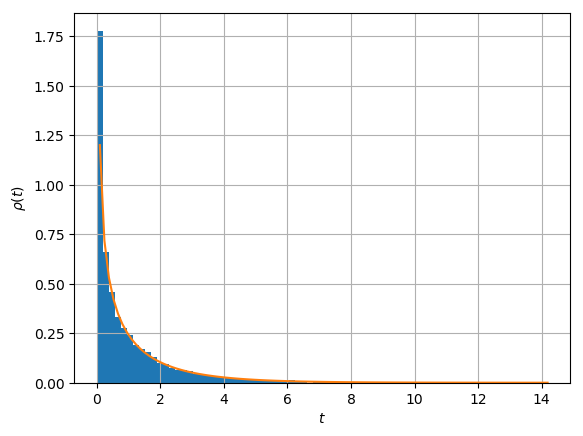

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13e257710>

In [8]:
using PyPlot
Nsmpl = 10000
#ξ = sampleMeasure(Nsmpl,opq)
#ysmpl = evaluatePCE(y,ξ,opq)
ysmpl = samplePCE(Nsmpl,y,opq)
figure(1)
plt[:hist](ysmpl; density=true,bins=75)
grid(true); xlabel(L"$t$"); ylabel(L"$\rho(t)$");

import SpecialFunctions: gamma
ρ(t) = 1/(sqrt(2)*gamma(0.5))*1/sqrt(t)*exp(-0.5*t)
t = range(0.1; stop=maximum(ysmpl), length=100)
plot(t,ρ.(t))